<font size=25>Laboratory 4 summary</font>

In this lab you will gain debugging experience by solving the most typical deep learning bugs.

There are 13 exercises, each one with a corresponding cell. Run the cell, inspect the error and fix the code.

Tips:
 - the bugs can be fixed in several lines of code (usually one or two)
 - some code in the sections must not be modified and is clearly delimited with comments
 - try not to inspect other exercises while solving the current one

# **Exercises**

Run the cell below to import the packages, which are required for all the exercises below.

In [1]:
from __future__ import print_function, division
import os
import torch
import random
from typing import Iterator, List, Callable, Tuple
from functools import partial
import warnings
from math import *
import zipfile
from tqdm import tqdm
from PIL import Image

# Sklearn
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
# Numpy
import numpy as np
# Pandas
import pandas as pd

# PyTorch packages
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils, datasets
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn as nn
import torch.optim as optim

# matplotlib
from matplotlib import rc, cm
rc('animation', html='jshtml')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
%matplotlib notebook
#warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

## Exercise 1: Getting started


In [4]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size #100
        self.hidden_size = hidden_size #256
        self.hidden_layer = nn.Linear(input_size, hidden_size) #(100, 256)
        self.output_layer = nn.Linear(hidden_size, 2) # 256
        self.activation_fn = activation_fn # relu

    def forward(self, x):
        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# DO NOT MODIFY MODEL INSTANTIATION BELOW
#####################################################################
model = MLP(input_size=100, hidden_size=256, activation_fn=nn.ReLU())
#####################################################################

x = torch.rand(32, 100)

y = model(x)
assert y.shape[0] == 32 and y.shape[1] == 2, "Wrong output shape"

## Exercise 2: Getting in shape

In [9]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int, #784
                 hidden_size: int, #256
                 activation_fn: Callable): #relu
        super().__init__()
        self.input_size = input_size #784
        self.hidden_size = hidden_size #256
        self.hidden_layer = nn.Linear(input_size, hidden_size) #(784, 256)
        self.output_layer = nn.Linear(hidden_size, 2) # (512, 2)
        self.flatten_layer = nn.Flatten()
        self.activation_fn = activation_fn

    def forward(self, x):
        h = self.flatten_layer(x)
        h = self.hidden_layer(h)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# DO NOT MODIFY MODEL INSTANTIATION BELOW
#####################################################################
model = MLP(input_size=784, hidden_size=256, activation_fn=nn.ReLU())
#####################################################################

# download MNIST dataset
mnist_trainset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor())

# select 10th example
x, l = mnist_trainset[10]

y = model(x)

assert y.shape[0] == 1 and y.shape[1] == 2, "Wrong output shape"

## Exercise 3: It's the little things


In [13]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 activation_fn: Callable): #relu
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 2)
        self.activation_fn = activation_fn

    def forward(self, x):
        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

model = MLP(input_size=784, hidden_size=256, activation_fn=nn.ReLU())

x = torch.rand(32, 784)
y = model(x)
assert y.shape[0] == 32 and y.shape[1] == 2, "Wrong output shape"

## Exercise 4: No one left behind

In [22]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int, #784
                 hidden_size: int,#256
                 batch_size: int, #BATCH_SIZE
                 activation_fn: Callable): #ReLU()
        super().__init__()
        self.input_size = input_size #784
        self.hidden_size = hidden_size #256
        self.hidden_layer = nn.Linear(input_size, hidden_size) #(784, 256)
        self.output_layer = nn.Linear(hidden_size, 10) #(256, 10)
        self.batch_size = batch_size
        self.activation_fn = activation_fn

    def forward(self, x):
        # input x has shape: batch_size x 1 x 28 x 28
        # we resize it to:   batch_size x 784
        x = x.view(-1, 784)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# DO NOT MODIFY HYPERPARAMETERS AND MODEL INSTANTIATION BELOW
#############################################################
BATCH_SIZE=32
model = MLP(
    input_size=784,
    hidden_size=256,
    activation_fn=nn.ReLU(),
    batch_size=BATCH_SIZE
)
##############################################################

# instantiate MNIST dataset
val_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor())
print("validation dataset size = ", len(val_dataset))

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in val_dataloader:
    # batch_size x 2
    out = model(batch_images)
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

epoch_loss /= len(val_dataloader)
print("Validation loss = ", epoch_loss)

validation dataset size =  10000
Validation loss =  2.3022900694094526


## Exercise 5: Left to their own devices


In [37]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 batch_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.device = device
        self.batch_size = batch_size

    def forward(self, x):
        # move Tensor to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        x = x.view(self.batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# DO NOT MODIFY DEVICE TENSOR BELOW
#################################################################################
BATCH_SIZE=32
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)
#################################################################################


# instantiate model
model = MLP(
    input_size=784, hidden_size=256, activation_fn=nn.ReLU(), batch_size=32,
    device=device
)

# move model to GPU (Module.to() is an in-place operation, it recursively
# processes parameters inside your nn.Module)
model.to(device)

# instantiate MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor())
print("train dataset size = ", len(train_dataset))

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in train_dataloader:
    # move labels to GPU (if available)
    batch_labels = batch_labels.to(device)

    # batch_size x 2
    # feedforward
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

device =  cuda
train dataset size =  60000


## Exercise 6: Not exactly my type

### Task I

In [39]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 batch_size: int,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.batch_size = batch_size

    def forward(self, x):
        # reshape tensor
        # batch_size x 784
        x = x.view(self.batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# instantiate model
model = MLP(
    input_size=784, hidden_size=256, activation_fn=nn.ReLU(), batch_size=32
)

# instantiate MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in train_dataloader:
    # batch_size x 2
    # feedforward
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

train dataset size =  60000


### Task II

In [63]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 64
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=64, hidden_size=256, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# load the 1797 images from the Digits dataset:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html
# Images are grayscale digits from 0 to 9, stored as arrays of size 64 (8x8).
# Both images and labels are stored are NumPy arrays, so we need to convert
# them to Tensors.
x = load_digits()

# 1797 x 64, 1797
images, labels = torch.tensor(x.data), torch.tensor(x.target)

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (1797 in our case)
train_dataset = TensorDataset(images, labels)

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in train_dataloader:
    batch_labels=batch_labels.to(device)

    batch_images = batch_images.float()
    # batch_size x 2
    # feedforward
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

device =  cuda


## Exercise 7: Out of bounds
The [Wheat Seeds](https://archive.ics.uci.edu/ml/datasets/seeds) dataset ([Kaggle link](https://www.kaggle.com/jmcaro/wheat-seedsuci)) is a classification task with 3 classes, which contains 209 examples. Each example contains 7 geometrical properties of wheat seeds belonging to 3 varieties of wheat.

**Hint 1:** When training on GPUs, CUDA errors may be less helpful. Usually, errors such as "`RuntimeError: CUDA error: device-side assert triggered`" indicate a problem with an index, which may be too large. To get a more accurate error message, move the model and dataset to CPU, check the error again and try to fix it.

**Hint 2:** After fixing the code responsible for a CUDA error, you may still encounter the error when running on GPU. Try restarting the Colab Notebook (`Runtime` -> `Restart runtime`) and run the cells again.


In [81]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 3)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 7
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# if you encounter a vague CUDA error message, move the operations to CPU then
# run the code again. The error message is usually more helpful.
device = torch.device('cpu') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=7, hidden_size=128, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# download Wheat Seeds dataset
!wget --no-check-certificate \
https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv \
-O /tmp/wheat.csv

# read Wheat Seeds dataset from csv
# Dataset has 209 examples. Each example has 7 attributes (features).
# It's a classification task with 3 classes (1, 2 and 3)
data = pd.read_csv("/tmp/wheat.csv")

# put examples in a Tensor
x = torch.tensor(data.values, dtype=torch.float32)

# separate data and labels
data, labels = x[:,:-1], x[:,-1].long()

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (209 in our case)
validation_dataset = TensorDataset(data, labels)

# instantiate dataloader
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in validation_dataloader:
    batch_labels=batch_labels.to(device)

    # feedforward
    # batch_size x 3
    batch_labels -= 1
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)#out is size(32, 3), labels is size(32, )
    epoch_loss += loss.item()

epoch_loss /= len(validation_dataloader)
print("Validation loss = ", epoch_loss)

device =  cpu
--2025-03-19 15:04:40--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9301 (9.1K) [text/plain]
Saving to: ‘/tmp/wheat.csv’

/tmp/wheat.csv      100%[===================>]   9.08K  --.-KB/s    in 0s      

2025-03-19 15:04:40 (81.5 MB/s) - ‘/tmp/wheat.csv’ saved [9301/9301]

Validation loss =  3.2895468888538226


## Exercise 8: I have no memory of that

**Hint 1:** The error will appear after ~1 epoch

**Hint 2:** You do NOT need to modify the model's size to fix the memory bug

**Hint 3:** After getting the error message, you have to restart the machine:
  - restart Colab: `Runtime` -> `Restart runtime`
  - run the cell that imports packages
  - run the cell below

In [3]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size_1: int,
                 hidden_size_2: int,
                 hidden_size_3: int,
                 hidden_size_4: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_layer_1 = nn.Linear(input_size, hidden_size_1)
        self.hidden_layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.hidden_layer_3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.hidden_layer_4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.output_layer = nn.Linear(hidden_size_4, 10)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        x = x.view(-1, self.input_size)

        h1 = self.activation_fn(self.hidden_layer_1(x))
        h2 = self.activation_fn(self.hidden_layer_2(h1))
        h3 = self.activation_fn(self.hidden_layer_3(h2))
        h4 = self.activation_fn(self.hidden_layer_4(h3))
        out = self.output_layer(h4)

        return out

BATCH_SIZE=32
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

# DO NOT MODIFY MODEL INSTANTIATION BELOW
#########################################
model = MLP(
    input_size=784,
    hidden_size_1=16384,
    hidden_size_2=16384,
    hidden_size_3=16384,
    hidden_size_4=16384,
    activation_fn=nn.ReLU(),
    device=device
)
#########################################

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# instantiate MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor())
print("train dataset size = ", len(train_dataset))

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
num_batches = len(train_dataloader)
for epoch in range(20):
    for idx, (batch_images, batch_labels) in enumerate(train_dataloader):
        if idx % 50 == 0:
            print("epoch %d, batch %d/%d" % (epoch, idx, num_batches))

        # move labels to GPU (if available)
        batch_labels=batch_labels.to(device)

        # batch_size x 2
        # feedforward
        out = model(batch_images)

        # compute loss
        loss = loss_crt(out, batch_labels)

        epoch_loss += loss.item()

        del batch_images
        del batch_labels

    epoch_loss /= num_batches
    print("epoch loss = ", epoch_loss)

device =  cuda
train dataset size =  60000
epoch 0, batch 0/1875
epoch 0, batch 50/1875
epoch 0, batch 100/1875
epoch 0, batch 150/1875
epoch 0, batch 200/1875
epoch 0, batch 250/1875
epoch 0, batch 300/1875
epoch 0, batch 350/1875
epoch 0, batch 400/1875
epoch 0, batch 450/1875
epoch 0, batch 500/1875
epoch 0, batch 550/1875
epoch 0, batch 600/1875
epoch 0, batch 650/1875
epoch 0, batch 700/1875
epoch 0, batch 750/1875
epoch 0, batch 800/1875
epoch 0, batch 850/1875
epoch 0, batch 900/1875
epoch 0, batch 950/1875
epoch 0, batch 1000/1875
epoch 0, batch 1050/1875
epoch 0, batch 1100/1875
epoch 0, batch 1150/1875
epoch 0, batch 1200/1875
epoch 0, batch 1250/1875
epoch 0, batch 1300/1875
epoch 0, batch 1350/1875
epoch 0, batch 1400/1875
epoch 0, batch 1450/1875
epoch 0, batch 1500/1875
epoch 0, batch 1550/1875
epoch 0, batch 1600/1875
epoch 0, batch 1650/1875
epoch 0, batch 1700/1875
epoch 0, batch 1750/1875
epoch 0, batch 1800/1875
epoch 0, batch 1850/1875
epoch loss =  2.30364788538614

KeyboardInterrupt: 

## Exercise 9: Underground

Validation accuracy on CIFAR10 with this simple MLP should reach ~48%. However, there is a bug preventing that from happening.

**Hint**: Inspect the training and validation losses.

In [15]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable,
                 output_activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.output_activation_fn = output_activation_fn
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)
        out = self.output_activation_fn(out)

        return out

BATCH_SIZE=128
NUM_EPOCHS=20
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

model = MLP(
    input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
    output_activation_fn=nn.Softmax(dim=0)
)
model.to(device)

# instantiate MNIST train and validation datasets
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
val_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))
print("validation dataset size = ", len(val_dataset))

# instantiate dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

# DO NOT MODIFY LOSS FUNCTION BELOW
##############################################################################
loss_crt = nn.NLLLoss()
##############################################################################

optimizer = optim.Adam(model.parameters(), lr=3e-4)
for epoch_idx in range(NUM_EPOCHS):
    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        # batch_size x 10
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)
        train_predictions += batch_predictions.tolist()
        train_labels += batch_labels.tolist()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

    with torch.no_grad():
        model.eval()
        model.zero_grad()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)
            val_predictions += batch_predictions.tolist()
            val_labels += batch_labels.tolist()

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    train_acc = accuracy_score(train_labels, train_predictions)
    val_acc = accuracy_score(val_labels, val_predictions)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print("epoch %d, train acc=%f, val acc=%f" % (
        epoch_idx,
        train_acc,
        val_acc
    ))


device =  cuda
train dataset size =  50000
validation dataset size =  10000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 0, train acc=0.288060, val acc=0.302500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 1, train acc=0.297280, val acc=0.311200


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 2, train acc=0.302327, val acc=0.313667


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 3, train acc=0.306575, val acc=0.315525


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 4, train acc=0.310256, val acc=0.315140


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 5, train acc=0.311767, val acc=0.316533


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 6, train acc=0.314014, val acc=0.317329


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 7, train acc=0.315460, val acc=0.319563


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 8, train acc=0.316798, val acc=0.320244


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 9, train acc=0.318242, val acc=0.320860


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 10, train acc=0.319433, val acc=0.322473


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 11, train acc=0.320913, val acc=0.323567


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 12, train acc=0.321994, val acc=0.324585


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 13, train acc=0.322931, val acc=0.325607


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 14, train acc=0.323961, val acc=0.325853


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 15, train acc=0.324852, val acc=0.326875


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 16, train acc=0.326058, val acc=0.327518


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 17, train acc=0.327003, val acc=0.328594


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 18, train acc=0.328019, val acc=0.329163


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 19, train acc=0.328843, val acc=0.330115


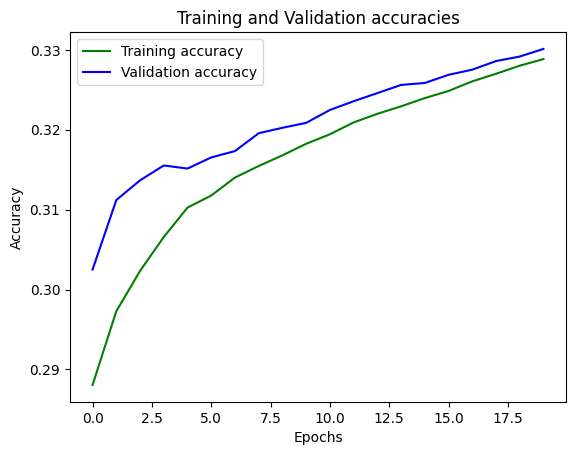

In [16]:
%matplotlib inline
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

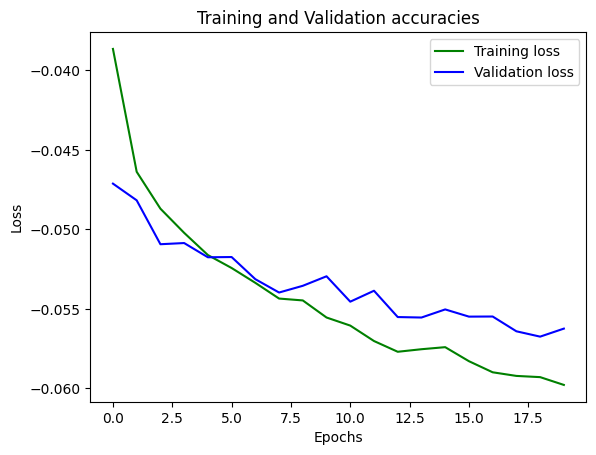

In [17]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exercise 10: Validation >> Train

Train the network and inspect the train and validation accuracy curves. Notice a large gap in accuracy (>5%) throughout the epochs. You have adjust the code below such that:
 - the accuracy gap between train and validation becomes smaller
 - validation performance gets better

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable,
                 dropout_rate: float):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(p=dropout_rate)
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h = self.activation_fn(self.dropout(self.hidden_layer(x)))
        out = self.output_layer(h)

        return out

BATCH_SIZE=128
NUM_EPOCHS=20
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

model = MLP(
    input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
    dropout_rate=0.9
)
model.to(device)

# instantiate MNIST train and validation datasets
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
val_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))
print("validation dataset size = ", len(val_dataset))

# instantiate dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

# DO NOT MODIFY LOSS FUNCTION BELOW
##############################################################################
loss_crt = nn.CrossEntropyLoss()
##############################################################################

optimizer = optim.Adam(model.parameters(), lr=3e-4)
for epoch_idx in range(NUM_EPOCHS):
    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        # batch_size x 10
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)
        train_predictions += batch_predictions.tolist()
        train_labels += batch_labels.tolist()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)
            val_predictions += batch_predictions.tolist()
            val_labels += batch_labels.tolist()

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    train_acc = accuracy_score(train_labels, train_predictions)
    val_acc = accuracy_score(val_labels, val_predictions)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print("epoch %d, train acc=%f, val acc=%f" % (
        epoch_idx,
        train_acc,
        val_acc
    ))


device =  cuda
Files already downloaded and verified
Files already downloaded and verified
train dataset size =  50000
validation dataset size =  10000
epoch 0, train acc=0.180120, val acc=0.281100
epoch 1, train acc=0.193400, val acc=0.289700
epoch 2, train acc=0.201713, val acc=0.297700
epoch 3, train acc=0.206990, val acc=0.302050
epoch 4, train acc=0.210948, val acc=0.306620
epoch 5, train acc=0.214280, val acc=0.310767
epoch 6, train acc=0.217106, val acc=0.314529
epoch 7, train acc=0.219908, val acc=0.315775
epoch 8, train acc=0.222058, val acc=0.319067
epoch 9, train acc=0.223774, val acc=0.321100
epoch 10, train acc=0.225705, val acc=0.322645
epoch 11, train acc=0.227455, val acc=0.324350
epoch 12, train acc=0.228638, val acc=0.326254
epoch 13, train acc=0.229809, val acc=0.327800
epoch 14, train acc=0.230783, val acc=0.329400
epoch 15, train acc=0.231689, val acc=0.330331
epoch 16, train acc=0.232551, val acc=0.331365
epoch 17, train acc=0.233411, val acc=0.332850
epoch 18, tr

In [ ]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exercise 11: Blown out of proportions

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable,
                 output_activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.output_activation_fn = output_activation_fn
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)
        out = self.output_activation_fn(out)

        return out

BATCH_SIZE=128
NUM_EPOCHS=20
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

model = MLP(
    input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
    output_activation_fn=nn.Softmax(dim=0)
)
model.to(device)

# instantiate MNIST train and validation datasets
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
val_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))
print("validation dataset size = ", len(val_dataset))

# instantiate dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

avg_grad_norms = []

# DO NOT MODIFY LOSS FUNCTION BELOW
##############################################################################
loss_crt = nn.CrossEntropyLoss()
##############################################################################

optimizer = optim.Adam(model.parameters(), lr=3e-4)
for epoch_idx in range(NUM_EPOCHS):
    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        batch_labels = batch_labels.to(device)

        # feedforward
        # batch_size x 10
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)
        train_predictions += batch_predictions.tolist()
        train_labels += batch_labels.tolist()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()

        for name, param in model.named_parameters():
            epoch_grad_norms = []
            if param.grad is not None:
                epoch_grad_norms.append(torch.norm(param.grad).cpu().numpy())
            avg_grad_norms.append((sum(epoch_grad_norms) / len(epoch_grad_norms)))


        optimizer.step()
        train_epoch_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)
            val_predictions += batch_predictions.tolist()
            val_labels += batch_labels.tolist()

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    train_acc = accuracy_score(train_labels, train_predictions)
    val_acc = accuracy_score(val_labels, val_predictions)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print("epoch %d, train acc=%f, val acc=%f" % (
        epoch_idx,
        train_acc,
        val_acc
    ))

In [ ]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(0,len(avg_grad_norms)), avg_grad_norms, 'g')
plt.title('Avg gradient norms')
plt.xlabel('Epochs')
plt.ylabel('Grad norm')
plt.legend()
plt.show()

## Exercise 12: Let's set things in order...

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 3)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 7
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# if you encounter a vague CUDA error message, move the operations to CPU then
# run the code again. The error message is usually more helpful.
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=7, hidden_size=128, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# download Wheat Seeds dataset
!wget --no-check-certificate \
https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv \
-O /tmp/wheat.csv

# read Wheat Seeds dataset from csv
# Dataset has 209 examples. Each example has 7 attributes (features).
# It's a classification task with 3 classes (1, 2 and 3)
data = pd.read_csv("/tmp/wheat.csv")

# solution: subtract 1 from the `labels` tensor
x = torch.tensor(data.values, dtype=torch.float32)
data, labels = x[:,:-1], x[:,-1].long()-1

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (209 in our case)

train_percent = 0.75
num_samples = len(data)
train_indices = range(0, int(num_samples * train_percent))
valid_indices = range(int(num_samples * train_percent), len(data))


training_dataset = TensorDataset(data[train_indices], labels[train_indices])
validation_dataset = TensorDataset(data[valid_indices], labels[valid_indices])

# instantiate train dataloader
train_dataloader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE
)

# instantiate validation dataloader
val_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE
)

loss_crt = nn.CrossEntropyLoss()
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

loss_crt = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=3e-4)
NUM_EPOCHS = 100

for epoch_idx in range(NUM_EPOCHS):
    train_labels = []
    val_labels = []
    train_preds = []
    val_preds = []

    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_labels += batch_labels.tolist()
        train_preds += batch_predictions.tolist()

    val_preds = []
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()
            val_labels += batch_labels.tolist()
            val_preds += batch_predictions.tolist()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_acc = accuracy_score(train_labels, train_preds)
    valid_acc = accuracy_score(val_labels, val_preds)

    print("epoch %d, train loss=%f, val loss=%f, train acc=%f, val acc=%f" % (
        epoch_idx, train_epoch_loss, val_epoch_loss, train_acc, valid_acc
    ))

device =  cpu
--2024-03-19 14:00:43--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9301 (9.1K) [text/plain]
Saving to: ‘/tmp/wheat.csv’

/tmp/wheat.csv      100%[===================>]   9.08K  --.-KB/s    in 0.001s  

2024-03-19 14:00:44 (16.2 MB/s) - ‘/tmp/wheat.csv’ saved [9301/9301]

epoch 0, train loss=1.797644, val loss=2.491622, train acc=0.448718, val acc=0.000000
epoch 1, train loss=1.527023, val loss=2.227722, train acc=0.448718, val acc=0.000000
epoch 2, train loss=1.332701, val loss=2.019177, train acc=0.448718, val acc=0.000000
epoch 3, train loss=1.193527, val loss=1.880535, train acc=0.448718, val acc=0.000000
epoch 4, train loss=1.105950, val loss=1.806260, train a

## Exercise 13: Weighing the evidence


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 3)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 7
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# if you encounter a vague CUDA error message, move the operations to CPU then
# run the code again. The error message is usually more helpful.
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=7, hidden_size=128, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# download Wheat Seeds dataset
!wget --no-check-certificate \
https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv \
-O /tmp/wheat.csv

# read Wheat Seeds dataset from csv
# Dataset has 209 examples. Each example has 7 attributes (features).
# It's a classification task with 3 classes (1, 2 and 3)
data = pd.read_csv("/tmp/wheat.csv")

# solution: subtract 1 from the `labels` tensor
x = torch.tensor(data.values, dtype=torch.float32)
data, labels = x[:,:-1], x[:,-1].long()-1

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (209 in our case)

train_percent = 0.75
num_samples = len(data)
train_indices = range(0, int(num_samples * train_percent))
valid_indices = range(int(num_samples * train_percent), len(data))

class_counts = {
    0: 15,
    1: 65,
    2: 15
}

train_indices = []
for cls in class_counts.keys():
    cls_indices = (labels == cls).nonzero().reshape((-1)).tolist()
    train_indices += cls_indices[:class_counts[cls]]

valid_indices = list(set(range(num_samples)) - set(train_indices))

training_dataset = TensorDataset(data[train_indices], labels[train_indices])
validation_dataset = TensorDataset(data[valid_indices], labels[valid_indices])

# instantiate train dataloader
train_dataloader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE
)

# instantiate validation dataloader
val_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE
)

loss_crt = nn.CrossEntropyLoss()
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

loss_crt = nn.CrossEntropyLoss(weight=torch.Tensor(
      [count / len(train_indices) for (cls, count) in class_counts.items()]
    ))

optimizer = optim.Adam(model.parameters(), lr=3e-4)
NUM_EPOCHS = 300

for epoch_idx in range(NUM_EPOCHS):
    train_labels = []
    val_labels = []
    train_preds = []
    val_preds = []

    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_labels += batch_labels.tolist()
        train_preds += batch_predictions.tolist()

    val_preds = []
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()
            val_labels += batch_labels.tolist()
            val_preds += batch_predictions.tolist()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_acc = accuracy_score(train_labels, train_preds)
    valid_acc = accuracy_score(val_labels, val_preds)

    print("epoch %d, train loss=%f, val loss=%f, train acc=%f, val acc=%f" % (
        epoch_idx, train_epoch_loss, val_epoch_loss, train_acc, valid_acc
    ))

device =  cpu
--2024-03-19 14:00:50--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9301 (9.1K) [text/plain]
Saving to: ‘/tmp/wheat.csv’

/tmp/wheat.csv      100%[===================>]   9.08K  --.-KB/s    in 0s      

2024-03-19 14:00:50 (126 MB/s) - ‘/tmp/wheat.csv’ saved [9301/9301]

epoch 0, train loss=5.201918, val loss=1.497913, train acc=0.157895, val acc=0.482456
epoch 1, train loss=4.565321, val loss=1.334123, train acc=0.157895, val acc=0.482456
epoch 2, train loss=3.947047, val loss=1.207482, train acc=0.157895, val acc=0.482456
epoch 3, train loss=3.347959, val loss=1.118400, train acc=0.157895, val acc=0.482456
epoch 4, train loss=2.771556, val loss=1.066557, train ac